In [2]:
#Importar librerías:
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy import stats
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

In [ ]:
#pip install statsmodels

### Estimacion de Máxima Verosimilitud

Los [datos](https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true) provienen del artículo de Daniel Treisman (2016), que concluye que Rusia tiene un número mayor de multimillonarios de lo que predicen factores económicos como el tamaño del mercado y la tasa impositiva. [Referencia](https://python.quantecon.org/mle.html)

In [3]:
#Carga de datos 
pd.options.display.max_columns = 10

# Carga de datos.
df = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true')
df.head()

country  ccode    year    cyear  numbil  ...   topint08     rintr  \
0  United States    2.0  1990.0  21990.0     NaN  ...  39.799999  4.988405   
1  United States    2.0  1991.0  21991.0     NaN  ...  39.799999  4.988405   
2  United States    2.0  1992.0  21992.0     NaN  ...  39.799999  4.988405   
3  United States    2.0  1993.0  21993.0     NaN  ...  39.799999  4.988405   
4  United States    2.0  1994.0  21994.0     NaN  ...  39.799999  4.988405   

   noyrs  roflaw  nrrents  
0   20.0    1.61      NaN  
1   20.0    1.61      NaN  
2   20.0    1.61      NaN  
3   20.0    1.61      NaN  
4   20.0    1.61      NaN  

[5 rows x 36 columns]

Al graficar el histograma de frecuencias se observa que la distribución tiene forma Poisson con cola larga

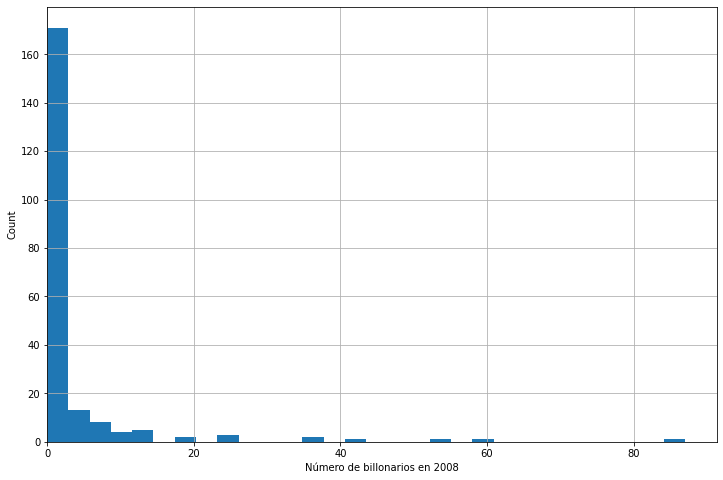

In [4]:
#Histograma de datos:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(left=0)
plt.grid()
plt.xlabel('Número de billonarios en 2008')
plt.ylabel('Count')
plt.show()

Códificamos la función de log-verosimilitud asociada a una ditribución Poisson. Crearemos una clase llamada Poisson para que podamos volver a calcular fácilmente los valores de la probabilidad de cada uno de los registros, el gradiente y el hessiano para cada iteración.

In [5]:
class Poisson:

    def __init__(self, y, X, β):
        self.X = X
        self.n, self.k = X.shape
        self.y = y.reshape(self.n,1)
        self.β = β.reshape(self.k,1)

    def μ(self):
        return np.exp(self.X @ self.β)

    def logL(self):
        y = self.y
        μ = self.μ()
        return np.sum(y * np.log(μ) - μ - np.log(factorial(y)))

    def G(self):
        y = self.y
        μ = self.μ()
        return X.T @ (y - μ)

    def H(self):
        X = self.X
        μ = self.μ()
        return -(X.T @ (μ * X))

Construímos la función de Newton-Raphson que permite un modelo como parámetro, a diferencia de la primera función de Newton-Raphson.

In [6]:
def newton_raphson_model(modelo, tolerancia=1e-3, maxiter=1000, display=True):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))

    while np.any(error > tolerancia) and i < maxiter:
        H, G = modelo.H(), modelo.G()
        β_new = modelo.β - (np.linalg.inv(H) @ G)
        error = β_new - modelo.β
        modelo.β = β_new

        # Print iterations
        if display:
            β_list = [f'{t:.3}' for t in list(modelo.β.flatten())]
            update = f'{i:<13}{modelo.logL():<16.8}{β_list}'
            print(update)

        i += 1

    print(f'Number of iterations: {i}')
    print(f'β_hat = {modelo.β.flatten()}')

    return modelo.β.flatten()

Ahora repliquemos los resultados del artículo de Daniel Treisman, Los multimillonarios de Rusia, mencionado anteriormente en el notebook.

Treisman comienza estimando la ecuación siguiente:

y_i es el número de multimillonarios i

x_i1 es logPIB per cápitai

x_i2 es logpoblacióni

x_i3 son años en GATTi - años de membresía en el GATT y la OMC (para poder acceder a los mercados internacionales)

Nota: Para este ejercicio solamente consideraremos datos del 2008.

In [7]:
# Solamente 2008
df = df[df['year'] == 2008]
# Agregar el intercepto
df['const'] = 1
# Regresiones Poisson.
reg = df[['const','lngdppc', 'lnpop', 'gattwto08', 'numbil0']]

In [8]:
reg.head()

const    lngdppc      lnpop  gattwto08  numbil0
18       1  10.786021  19.532846       60.0    469.0
44       1  10.743365  17.319439        0.0     25.0
70       1  10.072139  12.760934        0.0      0.0
95       1  10.223734  11.526276        0.0      0.0
120      1  11.446847  11.086334        0.0      0.0

In [9]:
reg.mean()

const         1.000000
lngdppc       8.560203
lnpop        15.191895
gattwto08    24.018780
numbil0       5.281690
dtype: float64

In [10]:
#Imputamos con la media
regf = reg.fillna(reg.mean())

In [11]:
### Separando y de x 
X = regf.iloc[:,[0,1,2,3]]
y = regf.iloc[:,[4]]

In [12]:
#convertimos a numpy
X = X.to_numpy()
y = y.to_numpy()

In [13]:
#Take a guess at initial βs
init_β = np.array([0.1, 0.1, 0.1, 0.1])
#Create an object with Poisson model values
poi = Poisson(y, X, β=init_β)

In [14]:
#Use newton_raphson to find the MLE
β_hat = newton_raphson_model(poi, display=True)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -inf            ['-0.932', '0.102', '0.103', '0.0994']
1            -inf            ['-2.02', '0.108', '0.111', '0.0978']
2            -inf            ['-3.26', '0.124', '0.132', '0.0937']
3            -inf            ['-4.93', '0.166', '0.188', '0.0837']
4            -inf            ['-7.81', '0.267', '0.321', '0.0632']
5            -inf            ['-13.3', '0.476', '0.582', '0.0354']
6            -inf            ['-21.0', '0.759', '0.894', '0.016']
7            -inf            ['-26.4', '0.969', '1.09', '0.00917']
8            -inf            ['-28.5', '1.06', '1.15', '0.00711']
9            -inf            ['-28.7', '1.07', '1.16', '0.00683']
10           -inf            ['-28.7', '1.07', '1.16', '0.00683']
Number of iterations: 11
β_hat = [-2.87359323e+01  1.07004016e+00  1.15985257e+00  6.8

In [20]:
#Probamos con el método de statmodels.
# Keep only year 2008
df2 = df[df['year'] == 2008]
# Add a constant
df2['const'] = 1
# Variable sets
reg2 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
poisson_reg = sm.Poisson(df[['numbil0']], df[reg2],
                         missing='drop').fit(cov_type='HC0')
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Sun, 06 Dec 2020   Pseudo R-squ.:                  0.8574
Time:                        01:26:41   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
lngdppc        1.0839      0.